<h2>Training dengan dataset timpang<h2>

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
import os
from PIL import Image
import random

In [2]:
# sapi
# direktori train test
train_dir= r'D:\BANGKIT2023\CAPSTONE\sapires\train'
test_dir= r'D:\BANGKIT2023\CAPSTONE\sapires\test'

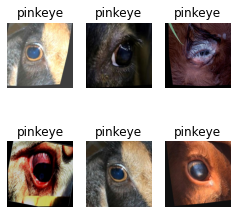

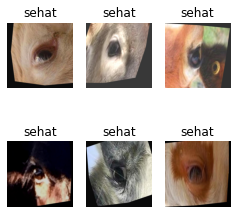

In [6]:
# list nama kelas
class_name = 'pinkeye'
class_name2 = 'sehat'

# list path gambar pada kelas yang dipilih
image_paths = os.listdir(os.path.join(train_dir, class_name))
image_paths2 = os.listdir(os.path.join(train_dir, class_name2))

# memilih 6 gambar secara acak dari kelas yang dipilih
image_paths = random.sample(image_paths, 6)
image_paths2 = random.sample(image_paths2, 6)

# menampilkan 6 gambar dari kelas yang dipilih
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(4, 4))
for i, ax in enumerate(axes.flat):
    img = image.load_img(os.path.join(train_dir, class_name, image_paths[i]))
    ax.imshow(img)
    ax.set_title(f"{class_name}")
    ax.axis('off')
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(4, 4))
for i, ax in enumerate(axes.flat):
    img = image.load_img(os.path.join(train_dir, class_name2, image_paths2[i]))
    ax.imshow(img)
    ax.set_title(f"{class_name2}")
    ax.axis('off')
plt.show()

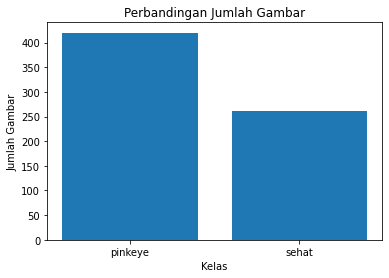

jumlah gambar sapi pinkeye =  420
jumlah gambar sapi sehat =  261


In [7]:
class_names = ['pinkeye', 'sehat']

# menghitung jumlah gambar pada setiap kelas
num_images = []
for class_name in class_names:
    num_images.append(len(os.listdir(os.path.join(train_dir, class_name))))

# menampilkan grafik perbandingan jumlah gambar pada dua kelas
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(class_names, num_images)
ax.set_title('Perbandingan Jumlah Gambar')
ax.set_xlabel('Kelas')
ax.set_ylabel('Jumlah Gambar')
plt.show()
print('jumlah gambar sapi pinkeye = ',num_images[0])
print('jumlah gambar sapi sehat = ',num_images[1])

In [8]:
# augmentasi data train
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=24,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.15,
                                   zoom_range=0.2,
                                   horizontal_flip=False)

# yang tes cmn rescale aja
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
# ukuran gambar dan batch nantinya
image_size = 224
batch_size = 32

# mempersiapkan data di preprosesing untuk train dan tes nantinya
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(image_size, image_size),
                                                    batch_size=batch_size,
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(image_size, image_size),
                                                  batch_size=batch_size,
                                                  class_mode='binary')


Found 681 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


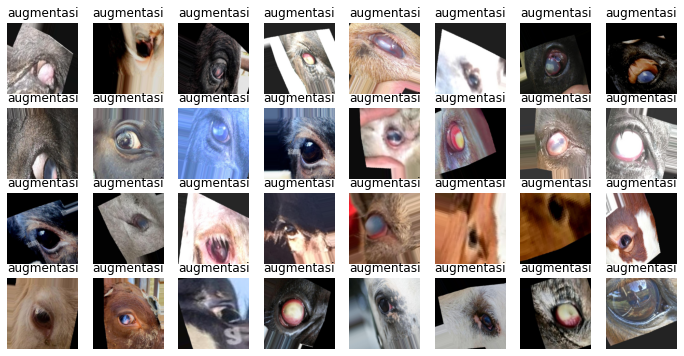

Jumlah gambar hasil augmentasi: 704


In [12]:
augmented_images, _ = train_generator.next()

# memvisualisasikan gambar setelah augmentasi
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.set_title('augmentasi')
    ax.imshow(augmented_images[i])
    ax.axis('off')
plt.show()
num_augmented_images = len(train_generator)* batch_size
print("Jumlah gambar hasil augmentasi:", num_augmented_images)

In [15]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

for layer in base_model.layers:
    layer.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [34]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])


In [35]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K

class LearningRateScheduler(Callback):
    def __init__(self, factor=0.1, patience=5, verbose=1):
        super(LearningRateScheduler, self).__init__()
        self.factor = factor
        self.patience = patience
        self.verbose = verbose
        self.best_val_acc = -1
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs['val_accuracy']
        
        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                old_lr = float(K.get_value(self.model.optimizer.lr))
                new_lr = old_lr * self.factor
                K.set_value(self.model.optimizer.lr, new_lr)
                if self.verbose > 0:
                    print(f"\nLearning rate decreased to {new_lr} after {self.wait} epochs of no improvement.")
                self.wait = 0


In [42]:

from tensorflow.keras.callbacks import EarlyStopping

num_epochs = 8

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', verbose=1)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping]
)

Epoch 1/8
21/21 [==============================] - 19s 887ms/step - loss: 0.0442 - accuracy: 0.9866 - val_loss: 0.3613 - val_accuracy: 0.8929
Epoch 2/8
21/21 [==============================] - 18s 843ms/step - loss: 0.0547 - accuracy: 0.9738 - val_loss: 0.3884 - val_accuracy: 0.8929
Epoch 3/8
21/21 [==============================] - 18s 848ms/step - loss: 0.0461 - accuracy: 0.9831 - val_loss: 0.3375 - val_accuracy: 0.8929
Epoch 4/8
21/21 [==============================] - 18s 853ms/step - loss: 0.0419 - accuracy: 0.9861 - val_loss: 0.3315 - val_accuracy: 0.8929
Epoch 4: early stopping


In [25]:
test_loss, test_acc = model.evaluate(validation_generator)
print('akurasi:', test_acc)

1/1 [==============================] - 1s 925ms/step - loss: 0.2966 - accuracy: 0.9286
akurasi: 0.9285714030265808


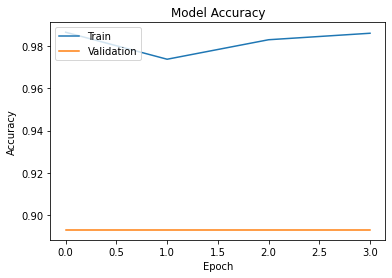

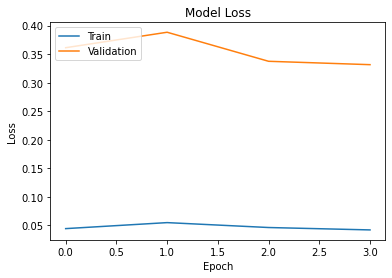

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


1/1 [==============================] - 2s 2s/step
Confusion Matrix:
[[18  1]
 [ 2  7]]
1/1 [==============================] - 1s 509ms/step


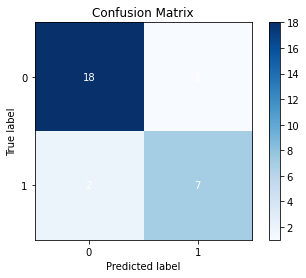

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Generate predictions for the test set
test_images, test_labels = validation_generator.next()  
predictions = model.predict(test_images) 

# Convert predicted probabilities to class labels
predicted_labels = np.where(predictions > 0.5, 1, 0)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

print("Confusion Matrix:")
print(cm)



# Generate predictions for the test set
test_images, test_labels = validation_generator.next()
predictions = model.predict(test_images)

# Convert predicted probabilities to class labels
predicted_labels = np.where(predictions > 0.5, 1, 0)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the confusion matrix as a table
im = ax.imshow(cm, cmap='Blues')

# Customize the plot
ax.set_xticks(np.arange(len(cm[0])))
ax.set_yticks(np.arange(len(cm)))
ax.set_xticklabels(['0', '1'])
ax.set_yticklabels(['0', '1'])
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

# Add labels to each cell in the table
for i in range(len(cm)):
    for j in range(len(cm[0])):
        text = ax.text(j, i, cm[i, j],
                       ha='center', va='center', color='white')

# Add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set the title
ax.set_title('Confusion Matrix')

# Display the plot
plt.show()


1/1 [==============================] - 0s 71ms/step


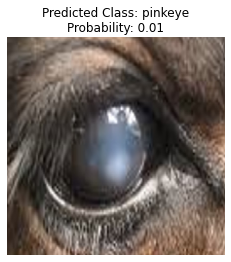

In [29]:
import matplotlib.pyplot as plt

# ambil dan prepros
test_image_path = r'D:\BANGKIT2023\CAPSTONE\layar.jpg' 
test_image = image.load_img(test_image_path, target_size=(image_size, image_size))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image / 255.0  # Normalize the image

# Memprediksi
predictions = model.predict(test_image)

# probability
predicted_class = "pinkeye" if predictions[0][0] < 0.5 else "sehat" 
probability = predictions[0][0]

# tampil
plt.imshow(test_image[0])
plt.title(f'Predicted Class: {predicted_class}\nProbability: {probability:.2f}')
plt.axis('off')
plt.show()


In [37]:
# model.save('model/sapi1mobilenet1.h5')